# Environment - Enhanced

In [2]:
import gym
from gym import spaces
import numpy as np
import matplotlib.pyplot as plt

import os
import random
import imageio
from tqdm import tqdm  
from itertools import count
from collections import namedtuple, deque

import torch
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.image as mpimg

In [3]:
class RoverGridEnv(gym.Env):
    metadata={'render.modes': ['human']} 
    def __init__(self, max_ts=20):     
        super(RoverGridEnv,self).__init__()
        self.max_ts=max_ts      # The Max_Timestamps is set to 20 by default.
        self.grid_size=(15,15)   
        self.action_space=spaces.Discrete(5) 
        self.observation_space=spaces.MultiDiscrete([15,15,15,15,15,15])
        self.rover_positions=np.array([[6,4],[10,4]])
        self.operation_desks=np.array([[6,3],[10,3]])
        self.rooms=np.array([[4,7],[4,10],[4,13],[8,7],[8,10],[8,13],[12,7],[12,10],[12,13]])
        self.human_position=np.array([8,9])
        self.targets=np.array([[5,10],[9,13]])
        self.actions=[(0,-1),(0,1),(-1,0),(1,0),(0,0)]  # Down,Up,Left,Right,Wait
        self.rover_done=[False,False] 
        self.reset()
    
    def seed(self,seed=None):
        np.random.seed(seed)
        random.seed(seed)
        
    def reset(self):
        self.current_step=0
        self.rover_positions=np.array([[6,4],[10,4]])
        self.rover_done=[False,False]
        self.human_position=np.array([7,8])
        self.current_step=0
        return self._get_obs()
    
    def _get_obs(self):
        return np.concatenate((self.rover_positions.flatten(),self.human_position))
    
    def step(self,actions):
        rewards=np.zeros(2)
        done=[False,False]
        info={'message': ''}        
        for i,action in enumerate(actions):
            if self.rover_done[i]:
                done[i]=True 
                continue
            prev_distance=np.linalg.norm(self.targets[i]-self.rover_positions[i])
            if self._is_human_adjacent(self.rover_positions[i]):
                rewards[i] -= 5
            else:
                delta=np.array(self.actions[action])
                new_position=self.rover_positions[i]+delta
                if self._out_of_bounds(new_position):
                    rewards[i] -= 15
                    continue
                if self._collision(new_position,i):
                    rewards[i] -= 15
                    continue
                self.rover_positions[i]=new_position
                new_distance=np.linalg.norm(self.targets[i]-new_position)
                if new_distance < prev_distance:
                    rewards[i]+=30 
                else:
                    rewards[i] -= 20 
                if np.array_equal(new_position,self.targets[i]):
                    rewards[i]+=100
                    self.rover_done[i]=True 
                    done[i]=True

        # move human randomly
        self._move_human()
        self.current_step+=1
        all_done=all(done) or self.current_step >= self.max_ts
        if all_done and not all(done):  # if the maximum number of steps is reached but not all targets were reached
            info['message']='Maximum number of timestamps reached'
        return self._get_obs(),rewards,all_done,info

    def _is_human_adjacent(self,position):
        for delta in [(1,1),(1,-1),(-1,1),(-1,-1)]:
            adjacent_position=position+np.array(delta)
            if np.array_equal(adjacent_position,self.human_position):
                return True
        return False

    def _out_of_bounds(self,position):
        return not (0 <= position[0] < self.grid_size[0] and 0 <= position[1] < self.grid_size[1])
    
    def _collision(self,new_position,rover_index):
        if any(np.array_equal(new_position,pos) for pos in np.delete(self.rover_positions,rover_index,axis=0)):
            return True  # Collision with the other rover
        if any(np.array_equal(new_position,pos) for pos in self.rooms):
            return True  # Collision with a room
        if any(np.array_equal(new_position,pos) for pos in self.operation_desks):
            return True  # Collision with an operation desk
        if np.array_equal(new_position,self.human_position):
            return True  # Collision with the human
        return False
    
    def _move_human(self):
        valid_moves=[move for move in self.actions if not self._out_of_bounds(self.human_position+np.array(move))]
        self.human_position+=np.array(valid_moves[np.random.choice(len(valid_moves))])
    
    # def render(self,mode='human',save_path=None):
    #     fig,ax=plt.subplots(figsize=(7,7))
    #     ax.set_xlim(0,self.grid_size[0])
    #     ax.set_ylim(0,self.grid_size[1])
    #     ax.set_xticks(np.arange(0,15,1))
    #     ax.set_yticks(np.arange(0,15,1))
    #     ax.grid(which='both')

    #     # draw elements
    #     for pos in self.rover_positions:
    #         ax.add_patch(Rectangle((pos[0]-0.5,pos[1]-0.5),1,1,color='blue'))
    #     for pos in self.operation_desks:
    #         ax.add_patch(Rectangle((pos[0]-0.5,pos[1]-0.5),1,1,color='darkgreen'))
    #     for pos in self.rooms:
    #         ax.add_patch(Rectangle((pos[0]-0.5,pos[1]-0.5),1,1,color='black'))
    #     ax.add_patch(Rectangle((self.human_position[0]-0.5,self.human_position[1]-0.5),1,1,color='purple'))
    #     for pos in self.targets:
    #         ax.add_patch(Rectangle((pos[0]-0.5,pos[1]-0.5),1,1,color='yellow',alpha=0.5))

    #     if save_path is not None:
    #         plt.savefig(save_path)
    #         plt.close()
    
    # def close(self):
    #     plt.close()

    def render(self, mode='human', save_path=None):
        fig, ax=plt.subplots(figsize=(7,7))
        ax.set_xlim(0, self.grid_size[0])
        ax.set_ylim(0, self.grid_size[1])

        rover_start_img_path='images/rover_moving.png'   
        rover_moving_img_path='images/rover_moving.png' 
        rover_dest_img_path='images/rover_dest.png'     
        rover_human_collision_path='images/rover_human_collision.png' 
        rover_room_collision_path='images/rover_room_collision.png'   
        rover_desk_collision_path='images/rover_desk_collision.png'   
        rover_rover_collision_path='images/rover_rover_collision.png' 
        desk_img_path='images/desk.png'
        room_img_path='images/room.png'   
        human_img_path='images/human.png' 
        target_img_path='images/target.png' 


        for i, pos in enumerate(self.rover_positions):
           
            if self.rover_done[i]:
                rover_img=mpimg.imread(rover_dest_img_path)  
            elif np.array_equal(pos, self.rover_positions[i]):
                rover_img=mpimg.imread(rover_start_img_path) 
            elif self._is_human_adjacent(pos):
                rover_img=mpimg.imread(rover_human_collision_path) 
            elif self._collision(pos, i):
               
                if any(np.array_equal(pos, pos) for pos in self.rooms):
                    rover_img=mpimg.imread(rover_room_collision_path)
                elif any(np.array_equal(pos, pos) for pos in self.operation_desks):
                    rover_img=mpimg.imread(rover_desk_collision_path)
                elif any(np.array_equal(pos, self.rover_positions[i]) for i in range(len(self.rover_positions)) if i != 0):
                    rover_img=mpimg.imread(rover_rover_collision_path)
            else:
                rover_img=mpimg.imread(rover_moving_img_path)  
            ax.imshow(rover_img, extent=(pos[0]-0.5, pos[0]+0.5, pos[1]-0.5, pos[1]+0.5))

      
        for pos in self.operation_desks:
            desk_img=mpimg.imread(desk_img_path)
            ax.imshow(desk_img, extent=(pos[0]-0.5, pos[0]+0.5, pos[1]-0.5, pos[1]+0.5))

        for pos in self.rooms:
            room_img=mpimg.imread(room_img_path)
            ax.imshow(room_img, extent=(pos[0]-0.5, pos[0]+0.5, pos[1]-0.5, pos[1]+0.5))

        human_img=mpimg.imread(human_img_path)
        ax.imshow(human_img, extent=(self.human_position[0]-0.5, self.human_position[0]+0.5, self.human_position[1]-0.5, self.human_position[1]+0.5))

        for pos in self.targets:
            target_img=mpimg.imread(target_img_path)
            ax.imshow(target_img, extent=(pos[0]-0.5, pos[0]+0.5, pos[1]-0.5, pos[1]+0.5))

        if save_path is not None:
            plt.savefig(save_path)
            plt.close()

    def close(self):
        plt.close()



Initial Setup


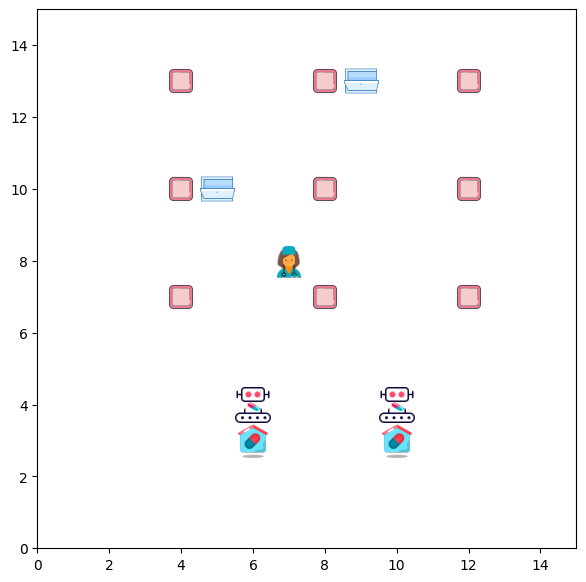

In [4]:
env=RoverGridEnv()
print("Initial Setup")
observation=env.reset()
env.render()